# Predicting Congenital Disorder using Support Vector Machines
https://www.kaggle.com/c/ga-dat-syd13/data

Author: <div class="LI-profile-badge"  data-version="v1" data-size="medium" data-locale="en_US" data-type="horizontal" data-theme="dark" data-vanity="aroraaman"><a class="LI-simple-link" href='https://au.linkedin.com/in/aroraaman?trk=profile-badge'>Aman Arora</a></div>  

**So, What is a congenital disorder?** <br> 
Most babies are born healthy, but when a baby has a condition that is present from birth, it is called a congenital disorder. Congenital disorders can be inherited or caused by environmental factors and their impact on a child’s health and development can vary from mild to severe. A child with a congenital disorder may experience a disability or health problems throughout life. (https://www.pregnancybirthbaby.org.au/what-is-a-congenital-disorder)

**Here are some of the resources that I referenced before creating this notebook:**<br>
1. https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python 
2. General Assembly, Sydney - Linear Regression iPython Notebook -
Authors: Kevin Markham (Washington, D.C.), Ed Podojil (New York City); <br>
Taught by: **Dima Galat** (https://www.linkedin.com/in/dimagalat/)
5. https://www.booktopia.com.au/multivariate-data-analysis-joe-f-hair/prod9781292021904.html?source=pla&gclid=EAIaIQobChMIpJ2qkJLO3QIV16mWCh3RBAFUEAQYASABEgL39vD_BwE (MultiVariate Data Analysis)
6. https://www-bcf.usc.edu/~gareth/ISL/ Introduction to Statistical Learning (James et al., 2014)
7. https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda
8. https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
9. https://www.kaggle.com/apapiu/regularized-linear-models

### Importing Libraries

In [1]:
#Getting the toolkit together
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.preprocessing import StandardScaler
plt.style.use("fivethirtyeight")
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,\
                            roc_curve,roc_auc_score,classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn import svm
from sklearn import metrics

### Data EDA

I performed initial EDA for this data set in my notebook 'Predicting Congenital Disorder using Resampling.ipynb'. Therefore, here I will just clean my data - remove nulls and implement Support Vector Machine model.

In [2]:
#importing data
train_path = '/Users/user/Desktop/Folders/Data_Scientist/Project 3_ GA/health-diagnostics-train.csv'
health_df =pd.read_csv(train_path)

# importing data
test_path = '/Users/user/Desktop/Folders/Data_Scientist/Project 3_ GA/health-diagnostics-test.csv'
health_df_test =pd.read_csv(test_path)

In [3]:
health_df.replace('#NULL!', np.NaN, inplace = True)
health_df_test.replace('#NULL!', np.NaN, inplace = True)

I have tried different combinations of imputing data and dropping data already while working on this exercise. It makes sense to impute the mode() in missing values as these are categorical features. However, imputing in test with mode() and dropping train values gives maximum accuracy. <br>
Why? Well, first of all we have over 30,000 values in train data. Losing 900 is approx 3% of the data. This data is not unique and exists for target == 0, that is, our majority class. We are not missing the minority class, therefore, it is safe to drop this data in Train. For our test data, we cannot drop any data and therefore, we will be imputing with mode(). 

In [4]:
health_df.dropna(inplace = True)
health_df_test = health_df_test.apply(lambda x:x.fillna(x.value_counts().index[0]))

**TRAIN TEST SPLIT**

In [5]:
X = health_df.loc[:, health_df.columns != 'target']
y = health_df['target']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.5, random_state = 123)

In [7]:
X_train.shape

(15217, 9)

In [8]:
X_test.shape

(15218, 9)

### Implementing Weighted Support Vector Machines 

In [9]:
target_count = pd.Series(y_train).value_counts()

print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion of majority to minority class:', round(target_count[0] / target_count[1], 2), ': 1')

prop = round(target_count[0] / target_count[1],2)

Class 0: 15188
Class 1: 29
Proportion of majority to minority class: 523.72 : 1


I ran random search followed by Grid Search to find the best class weight. It turns the best class weight was the inverse of proportion of class in our Dataset. It is also suggested in the research article "Predicting congenital heart defects: A comparison of three data mining methods" by Yanhong Luo. (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0177811)

the recall for this model is : 0.6
TP 18
TN 15099
FP 89
FN 12
AUC: 0.7970700553068213
TPR: 0.6
TNR: 0.9941401106136424
ACC: 0.9933631226179525
wtACC: 0.7182420331840926
G_mean: 0.7723238092718528
----------------------------------------------------------------------------------------------------
AUC score: 0.7970700553068213 for model: SVC(C=1.0, cache_size=200, class_weight={0: 0.0019094172458565645, 1: 1},
  coef0=0.0, decision_function_shape='ovr', degree=1, gamma='auto',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


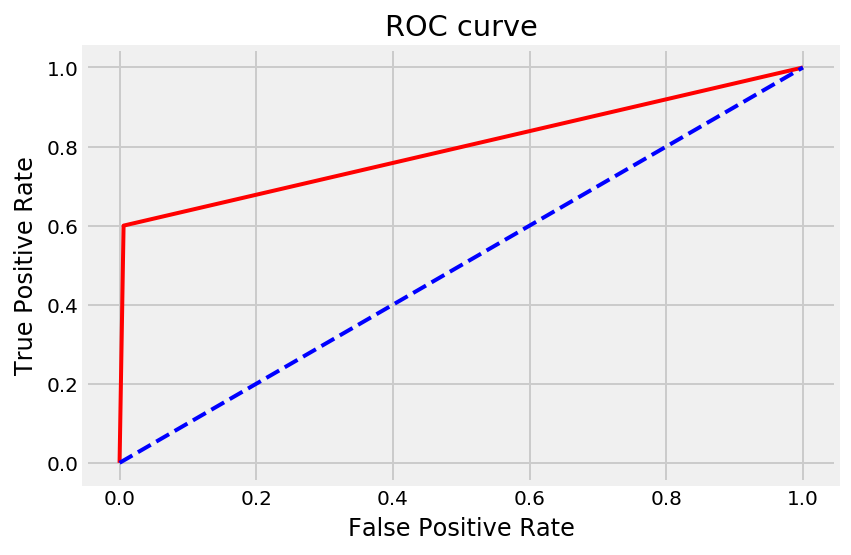

In [10]:
wclf = svm.SVC(kernel='linear', degree = 1,class_weight={0 : 1/(prop),
                                                         1 : 1})
wclf.fit(X_train,y_train)
y_pred = wclf.predict(X_test)

# Evaluations
cnf_matrix=confusion_matrix(y_test,y_pred)
TP = cnf_matrix[1,1,]
TN = cnf_matrix[0,0]
FP = cnf_matrix[0,1]
FN = cnf_matrix[1,0]
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
ACC = (TP+TN)/(TP+TN+FP+FN)
wtACC = (0.7*TPR) + (0.3*TNR)
G_mean = np.sqrt(TPR * TNR)
print("the recall for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0]))
print("TP",TP) 
print("TN",TN) 
print("FP",FP) 
print("FN",FN) 
print("AUC: {}".format(roc_auc_score(y_test, y_pred)))
print('TPR:',TPR)
print('TNR:',TNR)
print('ACC:',ACC)
print('wtACC:',wtACC)
print('G_mean:',G_mean)
print('-'*100)
fpr, tpr, threshold = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
print('AUC score:', auc_score, 'for model:',wclf)
plt.figure()
plt.plot(fpr, tpr, color='red',
lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

**HYPERPARAMETER TUNING**

In [11]:
class_weight=[{0: 1/prop, 1: w} for w in np.linspace(start = 1, stop = 3, num = 10)]
kernel = ['linear','rbf']
metrics = 'auc'
degree = [1,3,5,7,9,20]
gamma=[w for w in np.linspace(start = 1, stop = 1000, num = 10)]

param_grid = {'class_weight':class_weight,
               'kernel': kernel,
               'degree': degree,
               'gamma': gamma}

In [12]:
clf = SVC()

rand_search = RandomizedSearchCV(clf, 
                                 param_distributions = param_grid, verbose = 2,
                                 n_iter = 30, cv = 3, random_state = 123, scoring = 'roc_auc') 
rand_search.fit(X_train,y_train)

In [13]:
# DEFINE MODEL AND PERFORMANCE MEASURE
clf = SVC()

#after this I defined my Grid for grid search

grid_search = GridSearchCV(clf, param_grid = param_grid, cv = 3, scoring = 'roc_auc', verbose = 2) 
grid_search.fit(X_train, y_train) 
grid_search.cv_results_
               

rand_search.fit(X_train, y_train) 
rand_search.cv_results_